# DATA 601: HW4
## Fall 2019

### Due: Wed. Oct. 9, 2019 (by 23:55) 

**Learning Objectives**
- Work with more than one tabular dataset to compute quantities.
- Wrangle and organize data for the purpose of geographic visualization.
- Produce interactive charts and plots. 

_This is an individual homework assignment._ 

Please complete this homework assignment within the Jupypter notebook environment, by inserting Markdown and Code cells to properly format your answers. Please do not alter the question cells. 

Your completed Jupyter notebook is to be submitted via the HW4 dropbox on D2L.

## Question 1: Scatter Plot of Rainfall Channels

This question builds upon HW3. Please ask for assistance if you did not manage to complete the portion of HW3 related to this question.

Use the provided Calgary rainfall dataset as well as the dataset containing the locations of the rainfall channels to produce a visualization that: 
 - shows on a map scatter plot, the total amount of rainfall recorded by each channel for the *2018* rainfall season;
 - provides a hover interaction for each channel that shows as text the following: total rainfall for the season, the number of rainy days for the season, and the mean rainfall per day for all the days it rained.

In [54]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sg

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px


import plotly as plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)


#%matplotlib inline
mpl.rcParams['figure.dpi']= 96
mpl.style.use('ggplot')

In [55]:
 #Let's load some geographic data into a GeoDataFrame

census_file = './Census by Community 2019.geojson'
cendf = gpd.read_file(census_file)

In [56]:
## We can also perform a scatterplot on a map.
## Let's display the rain channels from the Rainfall dataset.
## But first a bit of wrangling to extract the lat / long

rain_location_file = "./Rain_Gauge_locations.csv"
clocs = pd.read_csv(rain_location_file,usecols=["CHANNEL", "Northing", "Easting"])
clocs.set_index('CHANNEL', inplace=True)
clocs.drop_duplicates(inplace=True)
clocs.sort_index(inplace=True)
clocs['Northing'] = clocs['Northing'].astype(float)
clocs['Easting'] = clocs['Easting'].astype(float)
clocs.drop(47, inplace=True)

#display(clocs)

In [57]:
historical_rainfall = pd.read_csv('Historical_Rainfall.csv')
historical_rainfall["TIMESTAMP"]=pd.to_datetime(historical_rainfall["TIMESTAMP"])
historical_rainfall.drop(columns = ['YEAR'],inplace=True)
historical_rainfall.drop(historical_rainfall[historical_rainfall['RG_ACTIVE']=='N'].index, inplace=True)

In [58]:
historical_rainfall['Year'] =pd.DatetimeIndex(historical_rainfall['TIMESTAMP']).year
historical_rainfall['Month'] =pd.DatetimeIndex(historical_rainfall['TIMESTAMP']).month
historical_rainfall['Day'] =pd.DatetimeIndex(historical_rainfall['TIMESTAMP']).day
rain_data = pd.DataFrame ({'YEAR':historical_rainfall['Year'],'MONTH':historical_rainfall['Month'],'DAY':historical_rainfall['Day'], 'CHANNEL':historical_rainfall['CHANNEL'],"RAINFALL":historical_rainfall['RAINFALL']})
rain_data = rain_data[rain_data['YEAR']== 2018]
grouping = rain_data.groupby(['CHANNEL','MONTH','DAY'])['RAINFALL']
grouped_data= grouping.sum().reset_index(name = 'RAINFALL')
#grouped_data = grouped_data.groupby(['CHANNEL']).count()
rainydays = grouped_data.groupby(['CHANNEL']).count().reset_index()
totalrain = grouped_data.groupby(['CHANNEL']).sum().reset_index()
meanrain = grouped_data.groupby(['CHANNEL']).mean().reset_index()
final_data = pd.DataFrame({'CHANNEL': rainydays['CHANNEL'], 'RAINY DAYS': rainydays['RAINFALL'], 'TOTAL RAINFALL': totalrain['RAINFALL'], 'MEAN' : meanrain['RAINFALL']})
# lets unstack to move the data logger values to columns 
#unstakeddata = totalDL.unstack()
#display (unstakeddata)
final_data.set_index('CHANNEL', inplace=True)
clocs = clocs.join(final_data)
clocs = clocs.drop(clocs[clocs['Northing'] == 0].index)
clocs = clocs.dropna()
#display(clocs)

In [59]:
# Now build a GeoDataFrame and plot it over the base map of Calgary communities

from shapely.geometry import Point

clocs['coordinates'] = list(zip(clocs.Easting, clocs.Northing))
clocs['coordinates'] = clocs['coordinates'].apply(Point)
locsdf = gpd.GeoDataFrame(clocs, geometry='coordinates')
locsdf.crs = {'init' :'epsg:4326'} # interpret the coordinates as lat/long

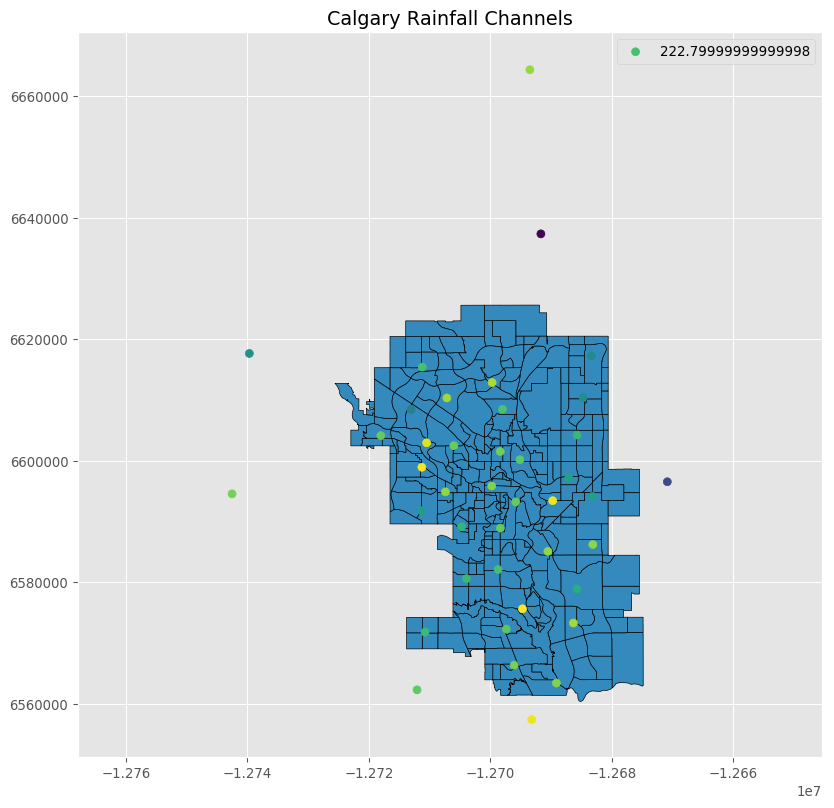

In [60]:
#display(clocs.head(3))
fig = plt.figure()
axis = fig.add_subplot(1,1,1)

# set the projection 
cendf = cendf.to_crs(epsg=3395) #3395 for mercator
locsdf = locsdf.to_crs(epsg=3395) 

cendf.plot(ax=axis, edgecolor='black')
clocs['TOTAL RAINFALL'] = np.abs(clocs['TOTAL RAINFALL'])
locsdf.plot(ax=axis,c=clocs['TOTAL RAINFALL']) 
plt.axis('equal')
plt.title('Calgary Rainfall Channels')
plt.legend(clocs['TOTAL RAINFALL'])
fig.set_size_inches(10,10)


In [61]:
## Interactive geo-vis on a mapbox base map using plotly

try:
    file = open('mapbox.token', 'r')
    for line in file:
        token = line.rstrip() # Use rstrip to get EOL-free lines
    file.close()
except FileNotFoundError as fnfe:
    print(fnfe)


text= []
lat = []
long = []
for index, row in clocs.iterrows():
    lat.append(row['Northing'])
    long.append(row['Easting'])
    text.append("Rainy Days: %s Total Rainfall %.2f Mean %.2f" % (row['RAINY DAYS'], row["TOTAL RAINFALL"], row["MEAN"]))
    
fig = go.Figure(go.Scattermapbox(
        lat=lat,
        lon=long,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9
        ),
        text=text,
    ))


# Try altering styles to one of: streets, light, dark, outdoors, satellite

fig.update_layout(
    title='Calgary Rainfall Channels',
    autosize=True,
    height=1024,
    hovermode='closest',
    mapbox=dict(
        style="streets",
        accesstoken=token,
        bearing=0,
        center=dict(  # These are Calgary coordinates
            lat=51.0486,
            lon=-114.0708
        ),
        pitch=0, # Pitch lets you pitch up or down
        zoom=10
    ),
)

fig.show()

## Question 2: Life Expectancy Index

The Life Expectancy Index ($\mathrm{LEI}$) is used as part of the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) which ranks countries into different tiers of human development. The $\mathrm{LEI}$ for a country is defined as:
$$
\mathrm{LEI} = \frac{\mathrm{LE} - 20}{85 - 20},  
$$
where $\mathrm{LE}$ is the life expectancy at birth.

*Using the provided datasets only*, perform the following tasks:
- Produce a choropleth world map visualization showing the $\mathrm{LEI}$ for the year 2017. Colour map the $\mathrm{LEI}$ values according to the following bins: $[0.5,0.6)$, $[0.6,0.7)$, $[0.7,0.8)$, $[0.8,0.9)$ and $[0.9,1)$, and use a visually distinct colour to identify countries for which the data is not available. 
- Please browse the [UNDP Human Development Reports](http://hdr.undp.org/en/data). This task asks you to produce a visualization that is inspired by the UNDP's visualization of the $\mathrm{LEI}$. Compute the $\mathrm{LEI}$ per country for all the years for which the data is available. Use k-means clustering to cluster the LEI series' into *four* clusters. Produce a visualization showing the LEI series' as lines for all the countries and colour the lines according to their cluster membership.

For bonus marks, please include informative non-default hover interactions in your visualizations to facilitate data exploration and comparison.

In [1]:
import numpy as np
import pandas as pd
import plotly as plotly
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
# for clustering
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode,iplot,plot

#plotly.__version__

In [2]:
LEI_data = pd.read_excel('Life expectancy at birth (years).xlsx',header=1,index_col=0)
display(LEI_data.head(4))
LEI_data.set_index('Country', inplace=True)

,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
HDI Rank (2017),,,,,,,,,,,,,,,,,,,,,
168,Afghanistan,49.9,50.6,51.3,52,52.5,53.1,53.5,54,54.5,...,60.2,60.8,61.2,61.7,62.1,62.5,62.9,63.3,63.7,64
68,Albania,71.8,71.8,71.8,71.9,72,72.2,72.5,72.8,73.2,...,75.9,76.3,76.7,77,77.4,77.7,78,78.2,78.3,78.5
85,Algeria,66.7,67,67.2,67.5,67.8,68.1,68.5,68.9,69.4,...,74,74.4,74.7,74.9,75.2,75.4,75.6,75.9,76.1,76.3
35,Andorra,76.5,76.7,76.9,77,77.2,77.4,77.6,77.9,78.2,...,80.6,80.7,80.8,80.9,81.1,81.2,81.3,81.4,81.5,81.7


In [3]:
LEI_data = LEI_data.apply( pd.to_numeric, errors='coerce' ) # changing the each cells to numeric, where value not availalbe changes to NA
LEI =LEI_data.iloc[:].apply(lambda x : (x-20)/(85-20)) # Calculating LEI for each cells 

display(LEI_data.head(3))
display(LEI.head(3))

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,49.9,50.6,51.3,52.0,52.5,53.1,53.5,54.0,54.5,55.0,...,60.2,60.8,61.2,61.7,62.1,62.5,62.9,63.3,63.7,64.0
Albania,71.8,71.8,71.8,71.9,72.0,72.2,72.5,72.8,73.2,73.6,...,75.9,76.3,76.7,77.0,77.4,77.7,78.0,78.2,78.3,78.5
Algeria,66.7,67.0,67.2,67.5,67.8,68.1,68.5,68.9,69.4,69.8,...,74.0,74.4,74.7,74.9,75.2,75.4,75.6,75.9,76.1,76.3


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.460000,0.470769,0.481538,0.492308,0.500000,0.509231,0.515385,0.523077,0.530769,0.538462,...,0.618462,0.627692,0.633846,0.641538,0.647692,0.653846,0.660000,0.666154,0.672308,0.676923
Albania,0.796923,0.796923,0.796923,0.798462,0.800000,0.803077,0.807692,0.812308,0.818462,0.824615,...,0.860000,0.866154,0.872308,0.876923,0.883077,0.887692,0.892308,0.895385,0.896923,0.900000
Algeria,0.718462,0.723077,0.726154,0.730769,0.735385,0.740000,0.746154,0.752308,0.760000,0.766154,...,0.830769,0.836923,0.841538,0.844615,0.849231,0.852308,0.855385,0.860000,0.863077,0.866154


In [4]:
country_codes = pd.read_csv('country_codes.csv')
country_codes=country_codes.apply(lambda x: x.str.strip())
#display(c_codes.head(3))
country_codes.set_index('Country', inplace=True)

#display(c_codes.head(3))
merged_LEI =pd.merge(country_codes, LEI, on='Country')
merged_LEI.columns
#display(m_LEI_index.head(3))
merged_LEI['Code']
merged_LEI.index
#m_LEI_index[2017]


Index(['Afghanistan', 'Angola', 'Albania', 'Andorra', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria',
       ...
       'Uzbekistan', 'Saint Vincent and the Grenadines',
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Vanuatu', 'Samoa',
       'Yemen', 'South Africa', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country', length=195)

In [18]:
data = dict(
        type = 'choropleth',
        locations = merged_LEI['Code'],
        z = merged_LEI[2017],
        text = merged_LEI.index,
        colorbar = {'title' : 'Life Expectency Index'},
        autocolorscale = False,
        colorscale=[[0.0, "red"],
                    [0.2, "red"],
                    [0.2, "blue"],
                    [0.4, "blue"],
                    [0.4, "green"],
                    [0.6, "green"],
                    [0.6, "purple"],
                    [0.8, "purple"],
                    [0.8, "orange"],
                    [1.0, "orange"]])  
layout = dict(title = '2017 Life Expectency Index',
                geo = dict(showframe = False,projection = {'type':'mercator'}))
choropleth = go.Figure(data = data,layout = layout)
iplot(choropleth)

In [67]:
tracers =[ go.Scatter(
    x = LEI.columns,
    y = LEI.loc[row],
    mode = "lines",
    name = row,
    #line=dict(color='firebrick', width=1),
) for row in LEI.index ]

In [68]:
#layout =go.Layout(title = "LEI Index of different countries")

layout =go.Layout(
    title=go.layout.Title(
        text="LEI Index of different countries",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Year",
            font=dict(
                family="Calibri, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="LEI-Index (Life Expectancy Index)",
            font=dict(
                family="Calibri, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

figure = go.Figure(data =tracers, layout=layout )
figure.show()
#py.plot(figure)

In [69]:
LEI_final = LEI_index.dropna()

## K- Mean Clustering

In [70]:
cluster = KMeans(n_clusters =4)

In [71]:
LEI_final['CLUSTER'] = cluster.fit_predict(LEI_final)

/global/software/jupyterhub-spark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [72]:
colors = ['burlywood',  'chartreuse', 'magenta', 'teal'] #Decided to be a little adventurous and funky with colors!
tracers =[go.Scatter(
    x = LEI_final.columns,
    y = LEI_final.loc[row],
    line=dict(color=colors[int(LEI_final.loc[row]['CLUSTER'])]),
    name = row,
) for row in LEI_final.index]

In [43]:
#layout =go.Layout(title = "LEI Index of different countries")

layout =go.Layout(
    title=go.layout.Title(
        text="Life Expectancy Index",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Year",
            font=dict(
                family="Calibri, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Life Expectancy Index",
            font=dict(
                family="Calibri, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

figure = go.Figure(data =tracers, layout=layout )
figure.update_yaxes(range=[0, 1])
figure.show()
#py.plot(figure)